# Demo of maximum likelihood estimation (MLE) for Lambert W x F distributions

This notebook illustrates how to estimate parameters of Lambert W x F distributions in `pylambertw` using

* **IGMM**: iterative generalized methods of moments (IGMM)

* **MLE**: maximum likelihood estimation for `torchlambertw.distributions.*` distributions


This is based on work in 


Goerg (2011). Lambert W random variables—a new family of generalized skewed distributions with applications to risk estimation. Ann. Appl. Stat. 5 (3) 2197 - 2230, 2011. https://doi.org/10.1214/11-AOAS457

Goerg (2015) The Lambert Way to Gaussianize Heavy-Tailed Data with the Inverse of Tukey’s h Transformation as a Special Case. The Scientific World Journal. Volume 2015 | Article ID 909231 | https://doi.org/10.1155/2015/909231


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Only run if not already on PYTHONPATH / venv
import os
import sys
import pathlib
from os.path import dirname
parent_path = dirname(pathlib.Path(pathlib.Path(os.getcwd())))

if parent_path not in sys.path:
    sys.path.insert(0, parent_path)

In [3]:
import torch
import scipy.special
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# import module for demo
import torchlambertw as tlw
from torchlambertw import distributions as tlwd
import pylambertw
import pylambertw.igmm
from pylambertw.utils import plot

/home/georg/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/georg/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


## Lambert W x Gaussian


Here is an illustration of a heavy-tail Lambert W x Gaussian distribution, which takes a Gaussian input and turns it into something heavy-tailed. If `tailweight = 0` then its just a Gaussian again.


In [4]:
# Use a slightly heavy-tailed distribution with a tail parameter of 0.25 (ie moments < 1/0.25 = 4 exist).
m = tlwd.TailLambertWNormal(loc=1.0, scale=3.0, tailweight=0.25)
m, type(m), isinstance(m, torch.distributions.Distribution)

(TailLambertWNormal(tailweight: 0.25),
 torchlambertw.distributions.TailLambertWNormal,
 True)

This is a `torch.distributions.Distributions` object; thus it has all the usual supported methods of distributions like sampling (`.sample()`), probability evaluation (`.log_prob()`), and moments (`.mean`, `.mode`, `.variance`, ...)

In [5]:
torch.manual_seed(0)
m.sample((2,)) 

tensor([7.2207, 0.1102])

In [6]:
print(m.tailweight, m.support, m.mean, m.variance)

tensor(0.2500) Real() tensor(1.) tensor(25.4558)


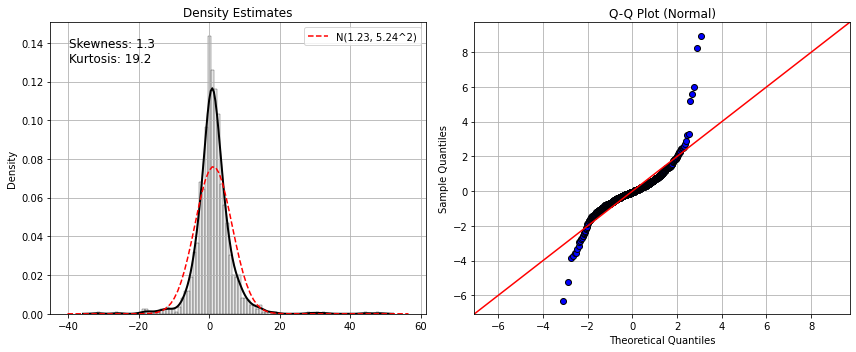

In [7]:
y = m.sample((1000,)).numpy().ravel()
plot.test_norm(y)

,loglik
normal,-3075.827637
normal_again,-3075.827637
lambertw_normal,-2869.566895


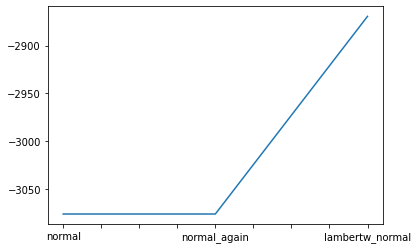

In [8]:
# assume its normal and eval likelihood
norm = torch.distributions.Normal(loc=y.mean(), scale=y.std())
# Set tailweight = 0 ('delta' in the papers), then a Lambert W x Normal is identical to Normal
norm_again = tlwd.TailLambertWNormal(loc=y.mean(), scale=y.std(), tailweight=0.0)

# Compare likelihood of all three distributions; since data was generated from `m`, should have highest likelihood.
def _loglik(dist, data):
    return dist.log_prob(torch.tensor(data)).sum().numpy().ravel()[0]
                         
total_logliks = pd.Series(
    {"normal": _loglik(norm, y),
     "normal_again": _loglik(norm_again, y),
     "lambertw_normal": _loglik(m, y)})
total_logliks.plot()
total_logliks.to_frame("loglik")


In [9]:
clf2 = pylambertw.igmm.IGMM(verbose=0, max_iter=100, lambertw_type="h")
clf2.fit(y)
clf2.tau

Lambert W x F (type: 'h')
	loc=[1.14274381]; scale=[3.0434256]
	delta: [0.26670558]; alpha: [1.]

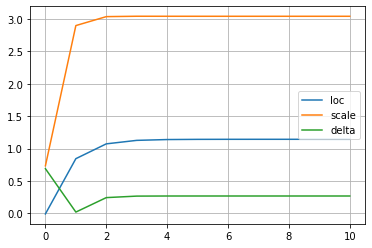

In [10]:
clf2.tau_trace.plot()
plt.grid()

Let's use the `MLE()` estimator / transformer to get parameters estimates given observed data.

In [11]:
import pylambertw.mle
clf = pylambertw.mle.MLE(verbose=10, max_iter=100, lambertw_type="h", distribution_name="Normal")
_ = clf.fit(y)

Epoch [10/100], Loss: 2877.3249681810485
Epoch [20/100], Loss: 2876.645715374273
Epoch [30/100], Loss: 2876.5736382168243
Epoch [40/100], Loss: 2876.5661543211513
Epoch [50/100], Loss: 2876.565375225551
Epoch [60/100], Loss: 2876.565334363666
Epoch [70/100], Loss: 2876.5652807981446
MLE
---
 Lambert W x Normal (type: 'h')
	loc=1.0546274371312754; scale=3.502391737695018
	delta: [0.24570121]; alpha: [1.]


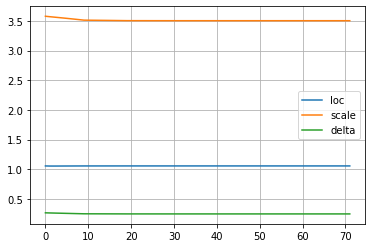

In [12]:
clf.theta_trace.plot()
plt.grid()

In [13]:
clf.theta

Lambert W x Normal (type: 'h')
	loc=1.0546274371312754; scale=3.502391737695018
	delta: [0.24570121]; alpha: [1.]

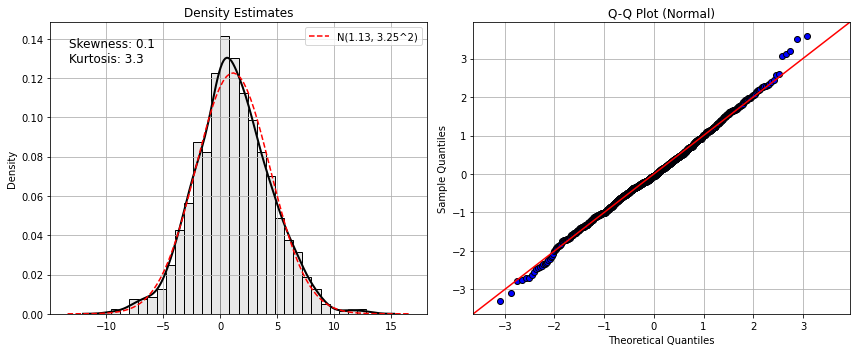

In [14]:
plot.test_norm(clf.transform(y))

## Skewed Lambert W x Exponential distributions

Lambert W x F distribution can be generated for any arbitratry F.  Here we show an example of a skewed Lambert W x Exponential distribution. For `skewweight > 0` , this will be more (right) skewed than a baseline exponential distribution. 

See Goerg (2011) and Kaarik et al. (2023).

In [15]:
torch.manual_seed(1)
m = tlwd.SkewLambertWExponential(rate=4., skewweight=0.2)
y2 = m.sample((1000,)).numpy().ravel()
print("mean: theoretical %f; empirical: %f" % (m.mean.numpy(), np.mean(y2)))

mean: theoretical 0.390625; empirical: 0.385927


Mean is larger than the 1/3. rate of the baseline exponential distribution because of the longer tail, which is also clearly visible in density chart and qqplot.

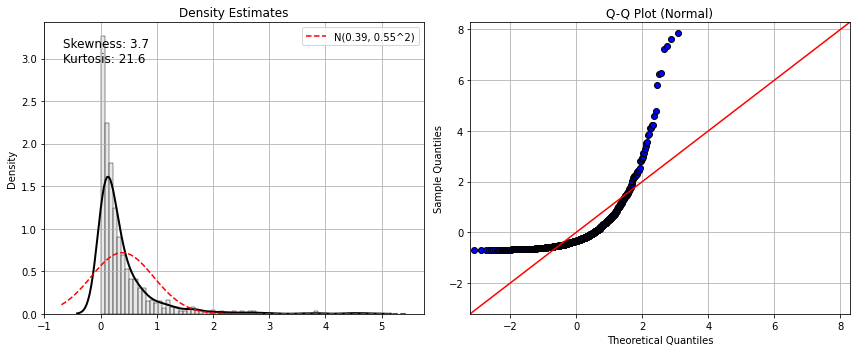

In [16]:
plot.test_norm(y2)

In [17]:
# Train a Lambert W x Weibull distribution
clf = pylambertw.mle.MLE(verbose=10, max_iter=100, lambertw_type="s", distribution_name="Exponential")
clf.fit(y2)

Epoch [10/100], Loss: -122.94792911699473
Epoch [20/100], Loss: -146.70370614539667
Epoch [30/100], Loss: -149.26910323087253
Epoch [40/100], Loss: -149.5384983633793
Epoch [50/100], Loss: -149.56620859374596
Epoch [60/100], Loss: -149.56898825687512
Epoch [70/100], Loss: -149.56925895937047
MLE
---
 Lambert W x Exponential (type: 's')
	rate=2.7725295841198374
	gamma: [0.09123325]


MLE(distribution_constructor=<class 'torch.distributions.exponential.Exponential'>,
    distribution_name='Exponential', lambertw_type=<LambertWType.S: 's'>,
    verbose=10)

In [18]:
clf.theta_init

Lambert W x Exponential (type: 's')
	rate=2.6665850197826515
	gamma: [0.01]

In [19]:
clf.theta_trace

,gamma,rate
0,0.020565,2.676419
1,0.027959,2.685722
2,0.034714,2.694521
3,0.041346,2.703327
4,0.048014,2.712326
...,...,...
72,0.091233,2.772530
73,0.091233,2.772530
74,0.091233,2.772530
75,0.091233,2.772530


In [20]:
clf.theta

Lambert W x Exponential (type: 's')
	rate=2.7725295841198374
	gamma: [0.09123325]

In [21]:
clf.theta_trace

,gamma,rate
0,0.020565,2.676419
1,0.027959,2.685722
2,0.034714,2.694521
3,0.041346,2.703327
4,0.048014,2.712326
...,...,...
72,0.091233,2.772530
73,0.091233,2.772530
74,0.091233,2.772530
75,0.091233,2.772530


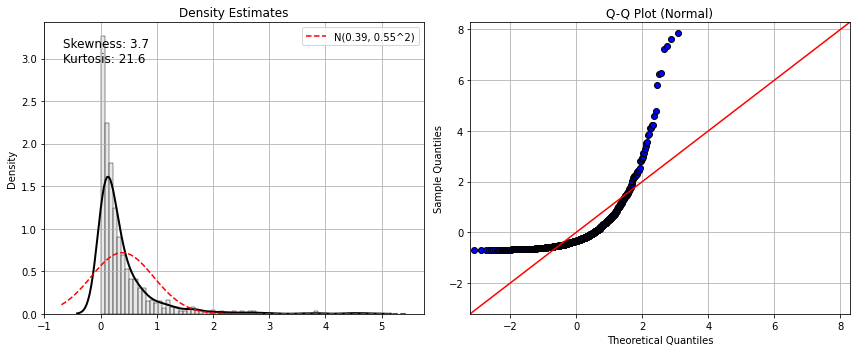

In [22]:
plot.test_norm(y2)

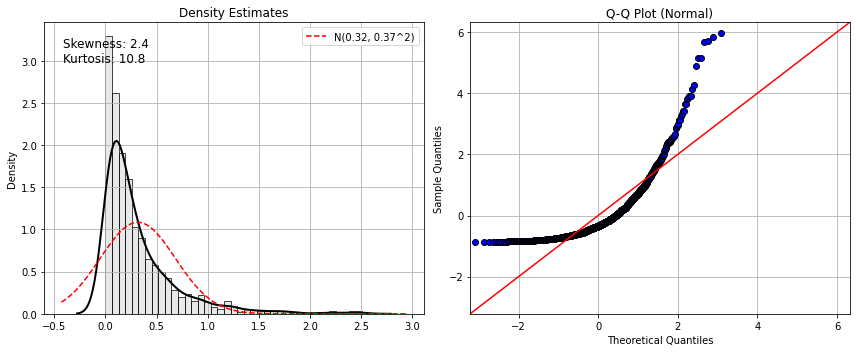

In [23]:
plot.test_norm(clf.transform(y2))